/home/bitzj/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


156017


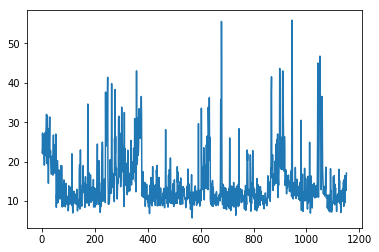

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy import  stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import scipy.io as sio

with open('T4.csv','r') as csvfile:
    reader = csv.DictReader(csvfile)
    column = [row['Total_CPU'] for row in reader]
print(len(column))
cpu = []
t = []
f_sample = 60
tmp = 0
step = 0
for i in range(12 * 96 * 60):
    if i % f_sample == 0 and i > 0:
        cpu.append(tmp / f_sample)
        tmp = 0
        step += 1
        t.append(step)
    if column[i] == "NULL":
        column[i] = "0.0"
    tmp += float(column[i])

plt.plot(t, cpu)
plt.show()
sio.savemat('CPU.mat', {'data': cpu})

[22.29774909 23.08888792 27.26659675 ... 12.62581672 14.2679375
 17.12359767]
[0.46007934, 0.5433262, 0.46381903, 0.43605408, 0.4405606, 0.5327843, 0.41328287, 0.38475055, 0.38045767]
Epoch: 100, Loss: 0.0089721540
Epoch: 200, Loss: 0.0083331391
Epoch: 300, Loss: 0.0074184500
Epoch: 400, Loss: 0.0079931095
Epoch: 500, Loss: 0.0070448522
Epoch: 600, Loss: 0.0058459598
Epoch: 700, Loss: 0.0041144197
Epoch: 800, Loss: 0.0028002006
Epoch: 900, Loss: 0.0021205791
Epoch: 1000, Loss: 0.0018643301


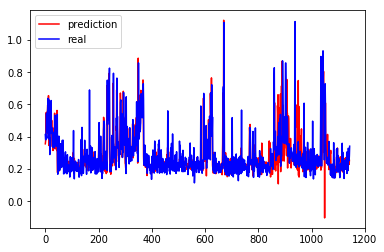

In [10]:
# -*- coding: utf-8 -*-
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt#matplotlib inline
import math

CPU_data = sio.loadmat("CPU.mat")["data"]
dataset=[]
for i in range(np.shape(CPU_data)[1]):
    dataset.append(CPU_data[0,i])
dataset=np.array(dataset)
print(dataset)
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))

def create_dataset(dataset, look_back=8):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

data_X, data_Y = create_dataset(dataset)

train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

import torch

train_X = train_X.reshape(-1, 1, 8)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 8)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)
from torch import nn
from torch.autograd import Variable
# 定义模型
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # 回归
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # 转换成线性层的输入格式
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x
net = lstm_reg(8, 20)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
# 开始训练
for e in range(1000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = net(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.10f}'.format(e + 1, loss.item()))
net = net.eval() # 转换成测试模式
data_X = data_X.reshape(-1, 1, 8)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X)
pred_test = net(var_data) # 测试集的预测结果
# 改变输出的格式
pred_test = pred_test.view(-1).data.numpy()
# 画出实际结果和预测的结果
plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset[7:], 'b', label='real')
plt.legend(loc='best')
plt.show()

In [11]:
plt.savefig("CPU.png")